In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

from scipy.optimize import minimize_scalar, brute
import scipy.optimize as optimize

%matplotlib inline

In [2]:
plt.style.use('seaborn-whitegrid')
img_path = "../reports/figures/"

In [3]:
# Task of interest
MU = 2.0
SIGMA = 1.0  # All formulas assume SIGMA=1.0, Do not change this value

# Visualizing the Task

In [4]:
def create_task(delta=0.0):
    y0 = np.random.normal(-MU + delta, 1, size=10000)
    y1 = np.random.normal(MU + delta, 1, size=10000)
    z = np.concatenate([y1, y0])
    return y0, y1, z

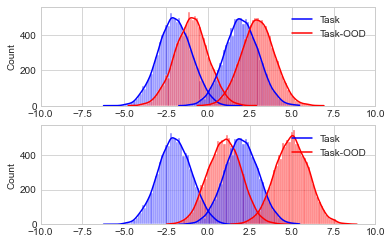

In [5]:
y0, y1, z = create_task()

plt.subplot(2, 1, 1)
ya0, ya1, za_ood = create_task(delta=1.0)
sns.histplot(y0,kde=True, color='blue')
sns.histplot(ya0,kde=True, color='red')
sns.histplot(y1, kde=True, color='blue')
sns.histplot(ya1, kde=True, color='red')
plt.legend(labels=["Task", "Task-OOD"], loc='upper right')
plt.xlim(-10, 10)

plt.subplot(2, 1, 2)
yb0, yb1, zb_ood = create_task(delta=3.0)
sns.histplot(y0,kde=True, color='blue')
sns.histplot(yb0,kde=True, color='red')
sns.histplot(y1, kde=True, color='blue')
sns.histplot(yb1, kde=True, color='red')
plt.legend(labels=["Task", "Task-OOD"], loc='upper right')

plt.xlim(-10, 10)

# plt.savefig(img_path + "01-gaussian_example.pdf", bbox_inches="tight")
plt.show()

In [6]:
def get_cdf(a, mean, std):
    a_norm = (a - mean) / std
    return norm.cdf(a_norm)

def err_h(h):
    # This is the error of a single hypothesis 'h'
    acc = get_cdf(h, MU, SIGMA) + 1 - get_cdf(h, -MU, SIGMA)
    acc = np.round(acc * 100, 4)
    return acc

In [7]:
# The Bayes optimal error:
MU = 2.0
print("Bayes optimal error when MU=%.1f is %.2f%%" % (MU, err_h(0)))

Bayes optimal error when MU=2.0 is 4.55%


In [8]:
def make_loss_plot(losses, fname):
    fig = plt.figure(figsize=(5,3))
    color_idx = np.linspace(0, 1, len(dlist))
    
    for i in range(len(dlist)):
        col = plt.cm.RdYlGn_r(color_idx[i])
        plt.plot(mnorm, losses[i], color=col)
        plt.scatter(mnorm, losses[i], alpha=0.5, s=5, color=col)

    plt.legend([str(d) for d in dlist], title='Delta', bbox_to_anchor = (1.05, 1.0))

    plt.xlabel("m/n, n=" + str(nval))
    plt.ylabel("Avg Risk")

    # plt.savefig(img_path + fname, bbox_inches="tight")
    plt.show()
    
def make_alpha_plot(alphas, fname):
    _ = plt.figure(figsize = (5, 3))
    color_idx = np.linspace(0, 1, len(dlist))

    for i in range(len(dlist)):
        col = plt.cm.RdYlGn_r(color_idx[i])
        plt.plot(mnorm, alpha_opt[i], color=col)
        plt.scatter(mnorm, alphas[i],alpha=0.5, s=5, color=col)
        leg = [str(d) for d in dlist]
        plt.legend(leg, bbox_to_anchor = (1.05, 1.0), title='Delta')
        plt.ylim([0, 1])
        plt.xlabel("m/n, n=" + str(nval))
        plt.ylabel("Alpha")

    # plt.savefig(img_path + fname, bbox_inches="tight")
    plt.show()

# "Multi-head" Classifier (by mixing hypotheses)

We compute the mean of all points from label1/label2 and the mid-point is used to classify both regions. 

The hypothesis $h_{id} =\frac{\mu(y_1) + \mu(y_2)}{2}$

Next, instead using just the hypothesis of original task data, we consider the hypothesis of the OOD data and weight it by alpha. Hence

$$h := \alpha  h_{id} + (1 - \alpha) h_{ood}$$

h is a Normal with $\mu =(1 - \alpha) \Delta$  and $\sigma^2 = \frac{2\alpha^2}{n} + \frac{2(1 - \alpha)^2}{m}$

In [9]:
MU = 2.0
mlist =  list(range(0, 50, 2)) +  list(range(50, 201, 5))
nval = 10
mnorm = [m/nval for m in mlist]
dlist = [0.0, 0.5, 0.75, 1.0, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0]

In [10]:
def compute_loss_multi(n=10, m=100, Delta=0.1, alpha=None):
    # If m=0, set alpha=1.0 for formulas to work (to avoid divide by 0 errors)
    m_flag = False
    if int(m) == 0:
        m_flag = True
        m = 10
    
    # Function to compute loss
    def loss(alpha):
        if alpha > 1.0 or alpha < 0.0:
            return 1
        
        sigma_bar =  np.sqrt( ((alpha**2) / n) +  ((1 - alpha)**2 / m) )
        mu_bar = (1 - alpha) * Delta
        term1 = 1
        term2 = norm.cdf((MU + mu_bar)/(np.sqrt(1 + sigma_bar**2)))
        term3 = norm.cdf((-MU + mu_bar)/(np.sqrt(1 + sigma_bar**2)))
        loss = (sigma_bar / 2) * (term1 - term2 + term3)
        return loss
    
    if m_flag:
        return 1.0, loss(1.0)
    elif alpha is None:
        # Brute force over alpha if no value specified
        res = brute(loss, ranges=[(0, 1)], Ns=100, full_output=True, finish=optimize.fmin)
        return res[0][0], res[1]
    else:
        return alpha, loss(alpha)

In [11]:
losses_alpha_fixed = []

for i, delta in enumerate(dlist):
    losses = []
    for m in mlist:
        _, loss = compute_loss_multi(n=nval, m=m, Delta=delta, alpha=nval/(nval+m))
        losses.append(loss)
         
    losses_alpha_fixed.append(losses)

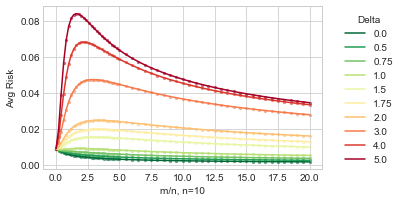

In [12]:
make_loss_plot(losses_alpha_fixed, "01-multihead_loss.pdf")

In [13]:
losses_alpha_opt = []
alpha_opt = []

for i, delta in enumerate(dlist):
    alphas = []
    losses = []
    for m in mlist:
        opt = compute_loss_multi(n=nval, m=m, Delta=delta)
        alphas.append(opt[0])
        losses.append(opt[1])
        
    losses_alpha_opt.append(losses)
    alpha_opt.append(alphas)

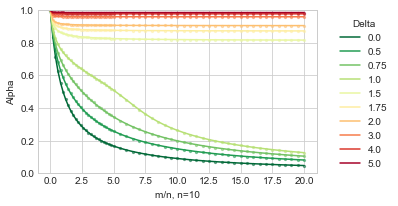

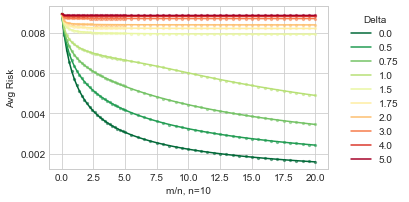

In [14]:
make_alpha_plot(alpha_opt, "01-multihead_opt_alpha.pdf")
make_loss_plot(losses_alpha_opt, "01-multihead_opt_loss.pdf")

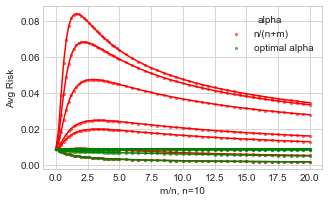

In [15]:
# Compare the losses of fixed alpha vs tuning for optimal alpha. 
fig = plt.figure(figsize=(5, 3))
cols = ('r', 'g')

labs = ('n/(n+m)', 'optimal alpha')

for ind, loss_comp in enumerate([losses_alpha_fixed, losses_alpha_opt]):
    for idx, lo in enumerate(loss_comp):
        if idx in [1, 2, 4]:
            continue
        
        if idx == 0:
            plt.scatter(mnorm, lo, alpha=0.5, s=5, color=cols[ind], label=labs[ind])
        else:
            plt.scatter(mnorm, lo, alpha=0.5, s=5, color=cols[ind])
        
        plt.plot(mnorm, lo, color=cols[ind])
    

plt.xlabel("m/n, n=" + str(nval))
plt.ylabel("Avg Risk")
plt.legend(title='alpha', loc='upper right')

# plt.savefig(img_path + "01-multihead_opt_vs_fixed.pdf", bbox_inches="tight")
plt.show()

# Single Head Classifier - LDA

We can derive similar expression for the case of LDA. Here we mix the datasets and train a single classifier head as opposed to mixing datasets.

We compute the mean of all points label1 and label2 points of the mixture dataset where
$$ \mu(y_1) = \frac{\alpha \sum_{x,y \in X_{t}} \ \ (x \times 1(y=1)) + (1 - \alpha) \sum_{x, y \in X_{ood}\ } \ \ \  
(x \times 1(y=1))}{\alpha n / 2 + (1 - \alpha)m/2 }$$

The final hypothesis is hypothesis 
$$h =\frac{\mu(y_1) + \mu(y_2)}{2}$$



In [16]:
def compute_loss_single(n=10, m=100, Delta=0.1, alpha=None):
    m_flag = False
    if int(m) == 0:
        m_flag = True
        m = 10
  
    def loss(alpha):
        if alpha > 1.0 or alpha < 0.0:
            return 1
        # Only next three lines change
        norm_val =  (alpha * n + (1 - alpha) * m)
        mu_bar =  ((1 - alpha) * m * Delta) / norm_val
        sigma_bar = (np.sqrt(( alpha**2 * n + (1 - alpha)**2 * m))) / norm_val
      
        term1 = 1
        term2 = norm.cdf((+MU + mu_bar)/(np.sqrt(1 + sigma_bar**2)))
        term3 = norm.cdf((-MU + mu_bar)/(np.sqrt(1 + sigma_bar**2)))
        ls = (sigma_bar / 2) * (term1 - term2 + term3)
        return ls
    
    if m_flag:
        return 0.5, loss(1.0)
    elif alpha is None:
        res = brute(loss, ranges=[(0, 1)], Ns=100, full_output=True, finish=optimize.fmin)
        return res[0][0], res[1]
    else:
        return alpha, loss(alpha)

In [17]:
MU = 2.0
mlist =  list(range(0, 50, 2)) +  list(range(50, 201, 5))
nval = 10
mnorm = [m/nval for m in mlist]
dlist = [0.0, 0.5, 0.75, 1.0, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0]

In [18]:
losses_alpha_fixed = []

for i, delta in enumerate(dlist):
    losses = []
    for m in mlist:
        _, loss = compute_loss_single(n=nval, m=m, Delta=delta, alpha=0.5)
        losses.append(loss)
        
    losses_alpha_fixed.append(losses)

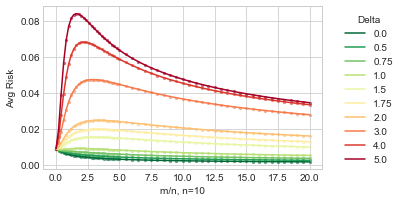

In [19]:
make_loss_plot(losses_alpha_fixed, "01-singlehead_loss.pdf")

In [20]:
losses_alpha_opt = []
alpha_opt = []

for i, delta in enumerate(dlist):
    alphas = []
    losses = []
    for m in mlist:
        opt = compute_loss_single(n=nval, m=m, Delta=delta)
        alphas.append(opt[0])
        losses.append(opt[1])
        
    losses_alpha_opt.append(losses)
    alpha_opt.append(alphas)

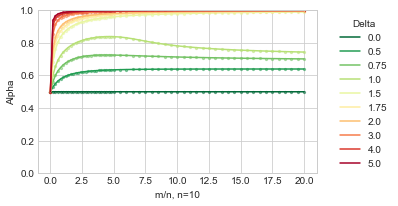

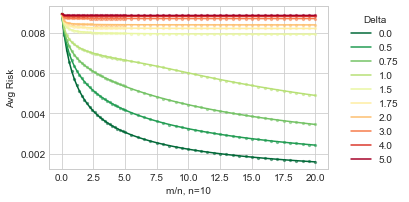

In [21]:
make_alpha_plot(alpha_opt, "01-singlehead_opt_alpha.pdf")
make_loss_plot(losses_alpha_opt, "01-singlehead_opt_loss.pdf")

# Reproducing Ashwin's setup

In [22]:
MU = 1.0
mlist =  list(range(0, 21, 1)) 
nval = 4
mnorm = [m/nval for m in mlist]
dlist = [0, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]

In [23]:
losses_alpha_fixed = []

for i, delta in enumerate(dlist):
    losses = []
    for m in mlist:
        _, loss = compute_loss_single(n=nval, m=m, Delta=delta, alpha=0.5)
        losses.append(loss)
        
    losses_alpha_fixed.append(losses)

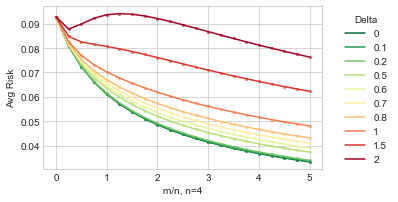

In [24]:
make_loss_plot(losses_alpha_fixed, "01-singlehead_loss_MU=1.pdf")